# YOLO Inference

In [1]:
import tensorflow as tf
import sys
import cv2
import numpy as np
from glob import glob
from models import Yolov4

In [2]:
#외부에서 import한 모듈을 수정사항 발생 시 매번 Reload하면 번거롭다.
#자동 리로드하는 방법을 알아보자.

%load_ext autoreload
%autoreload 2

In [3]:
model = Yolov4(weight_path='./yolov4.weights',
               class_name_path='./class_names/coco_classes.txt')

Metal device set to: Apple M1

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2022-07-19 11:27:15.517195: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-07-19 11:27:15.517299: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


nms iou: 0.413 score: 0.3
all weights read
load from ./yolov4.weights


/opt/homebrew/Caskroom/miniforge/base/envs/cv/lib/python3.8/site-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


img shape:  (878, 2048, 3)
1/1 [==============================] - 0s 301ms/step
# of bboxes: 28


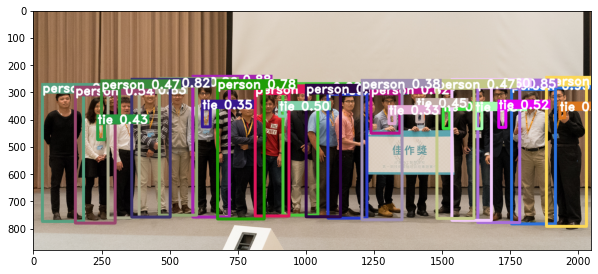

,x1,y1,x2,y2,class_name,score,w,h
0,1756,290,1917,782,person,0.947872,161,492
1,1884,274,2031,791,person,0.894209,147,517
2,917,297,1045,750,person,0.880508,128,453
3,586,270,720,757,person,0.879865,134,487
4,34,300,185,773,person,0.873772,151,473
5,815,305,939,753,person,0.864384,124,448
6,463,278,600,750,person,0.858891,137,472
7,1632,284,1786,777,person,0.845475,154,493
8,1082,308,1225,761,person,0.834839,143,453
9,275,306,389,760,person,0.832152,114,454


In [6]:
model.predict('./img/test.jpg', random_color=True)

Generate your annotation files (.XML) in VOC format for each images

HINT: An easily used annotation tool: <a href="https://github.com/heartexlabs/labelImg">labelImg</a>

Example: A 2 object xml file

# YOLO XML to csv

In [7]:
import xml.etree.ElementTree as ET
import os
from glob import glob

XML_PATH = './dataset/xml'
CLASSES_PATH = './class_names/voc_small_classes.txt'
TXT_PATH = './dataset/txt/anno.txt'


In [8]:
'''loads the classes'''
def get_classes(classes_path):
    with open(classes_path) as f:
        class_names = f.readlines()
    class_names = [c.strip() for c in class_names]
    return class_names

In [9]:
classes = get_classes(CLASSES_PATH)
assert len(classes) > 0, 'no class names detected!'
print(f'num classes: {len(classes)}')

num classes: 8


In [10]:
# output file
list_file = open(TXT_PATH, 'w')

In [11]:
for path in glob(os.path.join(XML_PATH, '*.xml')):
    in_file = open(path)

    # Parse .xml file
    tree = ET.parse(in_file)
    root = tree.getroot()
    # Write object information to .txt file
    file_name = root.find('filename').text
    print(file_name)
    list_file.write(file_name)
    for obj in root.iter('object'):
        cls = obj.find('name').text 
        cls_id = classes.index(cls)
        xmlbox = obj.find('bndbox')
        b = (int(xmlbox.find('xmin').text), int(xmlbox.find('ymin').text), int(xmlbox.find('xmax').text), int(xmlbox.find('ymax').text))
        list_file.write(" " + ",".join([str(a) for a in b]) + ',' + str(cls_id))
    list_file.write('\n')
list_file.close()

2007_000123.jpg
2007_000068.jpg
2007_000243.jpg
2007_000032.jpg
2007_000027.jpg
2007_000187.jpg
2007_000039.jpg


# YOLO TRAINING

In [12]:
from utils import DataGenerator, read_annotation_lines
from models import Yolov4
from config import yolo_config

In [13]:
train_lines, val_lines = read_annotation_lines('./dataset/txt/anno.txt', test_size=0.1)
FOLDER_PATH = './dataset/img'
class_name_path = './class_names/bccd_classes.txt'
data_gen_train = DataGenerator(train_lines, class_name_path, FOLDER_PATH)
data_gen_val = DataGenerator(val_lines, class_name_path, FOLDER_PATH)

In [20]:
'''
model.fit(data_gen_train, 
          initial_epoch=0,
          epochs=10,
          val_data_gen=data_gen_val,
          callbacks=[])
'''

'\nmodel.fit(data_gen_train, \n          initial_epoch=0,\n          epochs=10,\n          val_data_gen=data_gen_val,\n          callbacks=[])\n'